# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 8  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 8]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 2036.21826171875
iteration 0 loss 1165.7703857421875


iteration 500 loss 49.612613677978516


iteration 1000 loss 43.59764862060547


iteration 1500 loss 40.05846405029297


iteration 2000 loss 36.161136627197266


iteration 2500 loss 31.232139587402344


iteration 3000 loss 24.59345245361328


iteration 3500 loss 15.636693954467773


iteration 4000 loss 6.035475730895996


iteration 4500 loss 2.3546197414398193


iteration 5000 loss 1.5411279201507568


iteration 5500 loss 1.1276801824569702


iteration 6000 loss 0.8696528673171997


iteration 6500 loss 0.6902046203613281


iteration 7000 loss 0.5639492273330688


iteration 7500 loss 0.46963784098625183


iteration 8000 loss 0.3968666195869446


iteration 8500 loss 0.3401821553707123


iteration 9000 loss 0.29326173663139343


iteration 9500 loss 0.25451040267944336


iteration 10000 loss 0.22348880767822266


iteration 10500 loss 0.2035970389842987


iteration 11000 loss 0.1853000670671463


iteration 11500 loss 0.17367373406887054


iteration 12000 loss 0.16326162219047546


iteration 12500 loss 0.15635241568088531


iteration 13000 loss 0.14642518758773804


iteration 13500 loss 0.13957162201404572


iteration 14000 loss 0.1323135942220688


iteration 14500 loss 0.12824252247810364


iteration 15000 loss 0.12353537231683731


iteration 15500 loss 0.11815984547138214


iteration 16000 loss 0.11444293707609177


iteration 16500 loss 0.11067262291908264


iteration 17000 loss 0.11544898897409439


iteration 17500 loss 0.10377665609121323


iteration 18000 loss 0.10073067247867584


iteration 18500 loss 0.09740915894508362


iteration 19000 loss 0.09511946141719818


iteration 19500 loss 0.09235312789678574


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.08995191007852554


iteration 20500 loss 0.08974334597587585


iteration 21000 loss 0.08947733789682388


iteration 21500 loss 0.08913876861333847


iteration 22000 loss 0.08870886266231537


iteration 22500 loss 0.08816467970609665


iteration 23000 loss 0.08747914433479309


iteration 23500 loss 0.08662103116512299


iteration 24000 loss 0.08555503189563751


iteration 24500 loss 0.08424802869558334


iteration 25000 loss 0.08267099410295486


iteration 25500 loss 0.0807943195104599


iteration 26000 loss 0.07869352400302887


iteration 26500 loss 0.07669945061206818


iteration 27000 loss 0.07477174699306488


iteration 27500 loss 0.07297887653112411


iteration 28000 loss 0.07127971202135086


iteration 28500 loss 0.06964951753616333


iteration 29000 loss 0.06806400418281555


iteration 29500 loss 0.06663180887699127


iteration 30000 loss 0.06516674906015396


iteration 30500 loss 0.0637921616435051


iteration 31000 loss 0.06250391900539398


iteration 31500 loss 0.06126989796757698


iteration 32000 loss 0.06003937870264053


iteration 32500 loss 0.05884167551994324


iteration 33000 loss 0.05773504450917244


iteration 33500 loss 0.05668996647000313


iteration 34000 loss 0.055638667196035385


iteration 34500 loss 0.054644644260406494


iteration 35000 loss 0.05362684652209282


iteration 35500 loss 0.05273626372218132


iteration 36000 loss 0.05188985541462898


iteration 36500 loss 0.050961002707481384


iteration 37000 loss 0.050112176686525345


iteration 37500 loss 0.049251485615968704


iteration 38000 loss 0.04851005971431732


iteration 38500 loss 0.04770393297076225


iteration 39000 loss 0.04692322760820389


iteration 39500 loss 0.0461973212659359


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.045480962842702866


iteration 40500 loss 0.04540112987160683


iteration 41000 loss 0.04530161991715431


iteration 41500 loss 0.045179206877946854


iteration 42000 loss 0.04503117874264717


iteration 42500 loss 0.044855713844299316


iteration 43000 loss 0.044652510434389114


iteration 43500 loss 0.04442285746335983


iteration 44000 loss 0.044169437140226364


iteration 44500 loss 0.04389567673206329


iteration 45000 loss 0.04360572248697281


iteration 45500 loss 0.04330367222428322


iteration 46000 loss 0.04299844428896904


iteration 46500 loss 0.04269997775554657


iteration 47000 loss 0.04240407794713974


iteration 47500 loss 0.04211298003792763


iteration 48000 loss 0.04182487726211548


iteration 48500 loss 0.04153946042060852


iteration 49000 loss 0.04125739261507988


iteration 49500 loss 0.040978673845529556


iteration 50000 loss 0.04070227965712547


iteration 50500 loss 0.04042888060212135


iteration 51000 loss 0.04015764966607094


iteration 51500 loss 0.03988868370652199


iteration 52000 loss 0.039622094482183456


iteration 52500 loss 0.039358001202344894


iteration 53000 loss 0.03909582644701004


iteration 53500 loss 0.03883565589785576


iteration 54000 loss 0.038577694445848465


iteration 54500 loss 0.03832218423485756


iteration 55000 loss 0.03806893900036812


iteration 55500 loss 0.03781717270612717


iteration 56000 loss 0.03756731376051903


iteration 56500 loss 0.03731973469257355


iteration 57000 loss 0.037073876708745956


iteration 57500 loss 0.0368301197886467


iteration 58000 loss 0.036587994545698166


iteration 58500 loss 0.03634800761938095


iteration 59000 loss 0.03610990568995476


iteration 59500 loss 0.035873617976903915


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.03563864156603813


iteration 60500 loss 0.03561441972851753


iteration 61000 loss 0.03558903932571411


iteration 61500 loss 0.035562727600336075


iteration 62000 loss 0.03553571179509163


iteration 62500 loss 0.0355081781744957


iteration 63000 loss 0.03548024967312813


iteration 63500 loss 0.03545207157731056


iteration 64000 loss 0.035423729568719864


iteration 64500 loss 0.03539525717496872


iteration 65000 loss 0.03536674752831459


iteration 65500 loss 0.03533821925520897


iteration 66000 loss 0.03530968725681305


iteration 66500 loss 0.0352812297642231


iteration 67000 loss 0.03525276854634285


iteration 67500 loss 0.03522437438368797


iteration 68000 loss 0.035196028649806976


iteration 68500 loss 0.03516775742173195


iteration 69000 loss 0.03513956069946289


iteration 69500 loss 0.03511139750480652


iteration 70000 loss 0.03508331626653671


iteration 70500 loss 0.035055287182331085


iteration 71000 loss 0.03502730280160904


iteration 71500 loss 0.034999407827854156


iteration 72000 loss 0.03497150540351868


iteration 72500 loss 0.03494368493556976


iteration 73000 loss 0.03491588681936264


iteration 73500 loss 0.034888144582509995


iteration 74000 loss 0.03486041724681854


iteration 74500 loss 0.03483275696635246


iteration 75000 loss 0.03480512648820877


iteration 75500 loss 0.034777529537677765


iteration 76000 loss 0.034749966114759445


iteration 76500 loss 0.03472243621945381


iteration 77000 loss 0.03469494730234146


iteration 77500 loss 0.034667495638132095


iteration 78000 loss 0.03464007377624512


iteration 78500 loss 0.03461270406842232


iteration 79000 loss 0.034585319459438324


iteration 79500 loss 0.034558024257421494


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.034530725330114365


iteration 80500 loss 0.03452819585800171


iteration 81000 loss 0.03452565148472786


iteration 81500 loss 0.034523095935583115


iteration 82000 loss 0.034520573914051056


iteration 82500 loss 0.03451802581548691


iteration 83000 loss 0.03451550006866455


iteration 83500 loss 0.0345129519701004


iteration 84000 loss 0.034510403871536255


iteration 84500 loss 0.0345078706741333


iteration 85000 loss 0.03450533375144005


iteration 85500 loss 0.03450282663106918


iteration 86000 loss 0.03450028970837593


iteration 86500 loss 0.03449774160981178


iteration 87000 loss 0.03449521213769913


iteration 87500 loss 0.034492701292037964


iteration 88000 loss 0.03449014574289322


iteration 88500 loss 0.034487634897232056


iteration 89000 loss 0.0344851128757


iteration 89500 loss 0.034482572227716446


iteration 90000 loss 0.034480053931474686


iteration 90500 loss 0.03447753190994263


iteration 91000 loss 0.03447500616312027


iteration 91500 loss 0.03447248414158821


iteration 92000 loss 0.03446996212005615


iteration 92500 loss 0.0344674326479435


iteration 93000 loss 0.03446492552757263


iteration 93500 loss 0.03446241840720177


iteration 94000 loss 0.03445988893508911


iteration 94500 loss 0.03445737436413765


iteration 95000 loss 0.03445487469434738


iteration 95500 loss 0.034452345222234726


iteration 96000 loss 0.034449826925992966


iteration 96500 loss 0.034447330981492996


iteration 97000 loss 0.03444482013583183


iteration 97500 loss 0.034442294389009476


iteration 98000 loss 0.03443978726863861


iteration 98500 loss 0.034437280148267746


iteration 99000 loss 0.03443478047847748


iteration 99500 loss 0.03443226218223572


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
loss -6.0730695724487305


loss -49.631591796875


loss -71.64006805419922


loss -81.22290802001953


loss -84.78846740722656


loss -85.90634155273438


loss -86.18756103515625


loss -86.23927307128906


loss -86.24536895751953


loss -86.24577331542969


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578094482422


loss -86.24578857421875


loss -86.24578094482422


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


loss -86.24578857421875


final mse:  2.7876265740189865e-09
max, min: 1.9398489 -1.9190556
loss -6.0730695724487305


loss -49.57061767578125


loss -71.70056915283203


loss -80.46513366699219


loss -83.62200927734375


loss -84.70651245117188


loss -85.02458190917969


loss -85.09554290771484


loss -85.1063232421875


loss -85.1072998046875


loss -85.10733795166016


loss -85.10733795166016


loss -85.10734558105469


loss -85.10734558105469


loss -85.10733795166016


loss -85.10733795166016


loss -85.10734558105469


loss -85.10733795166016


loss -85.10734558105469


loss -85.10733795166016


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10733795166016


loss -85.10734558105469


loss -85.10733795166016


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10734558105469


loss -85.10733795166016


loss -85.10734558105469


loss -85.10733795166016


loss -85.10734558105469


final mse:  5.193251162438628e-09
max, min: 1.9521604 -1.9503112


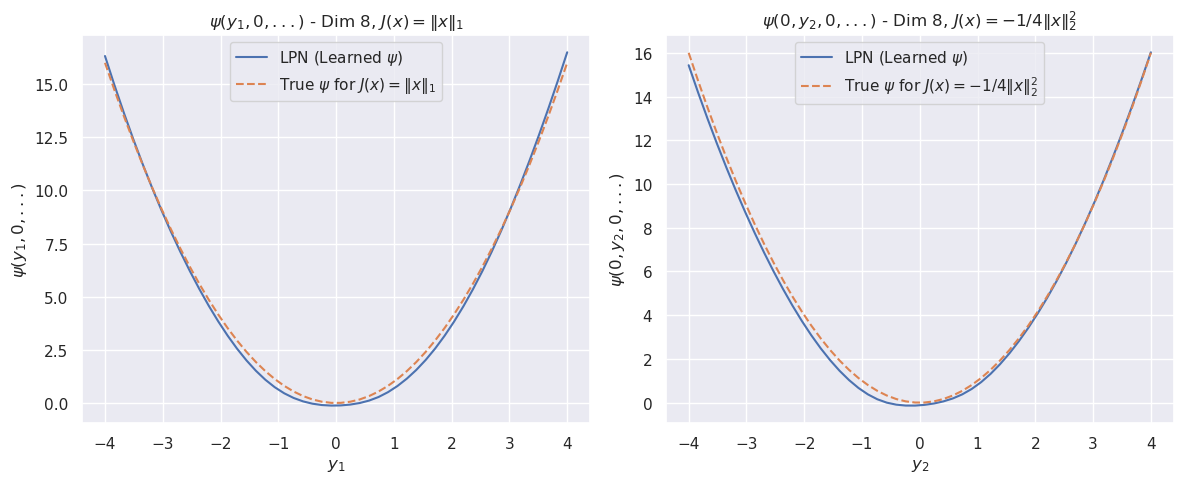

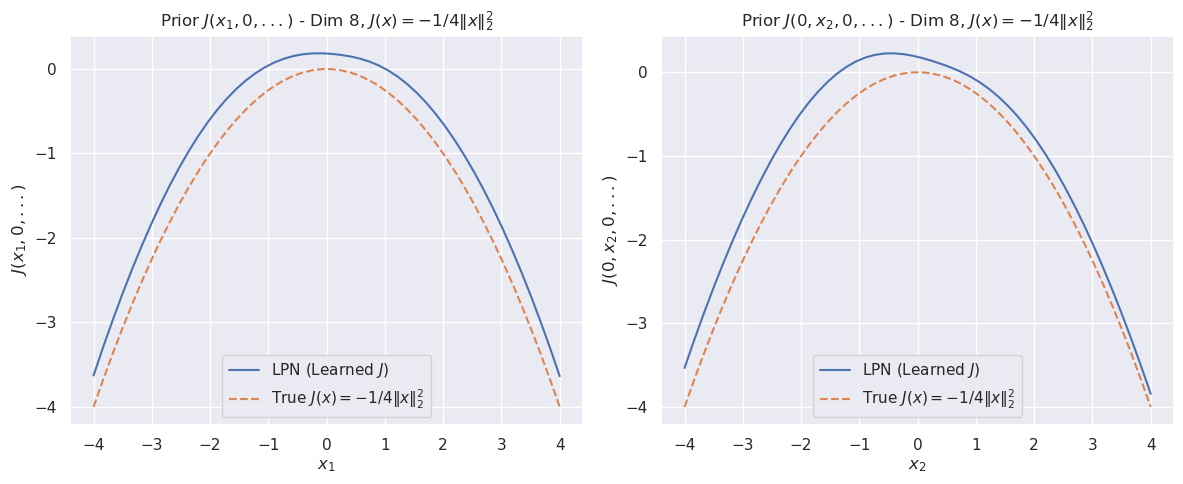

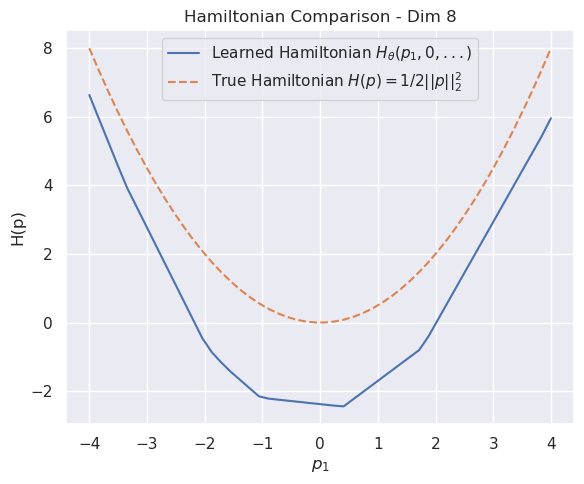

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_concave_quad(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


Generated G samples: G_samples_tensor shape torch.Size([30000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1977.9468994140625
iteration 0 loss 348.9626770019531


iteration 500 loss 43.42504119873047


iteration 1000 loss 39.94853210449219


iteration 1500 loss 36.37065124511719


iteration 2000 loss 31.949966430664062


iteration 2500 loss 26.179414749145508


iteration 3000 loss 18.169803619384766


iteration 3500 loss 7.790807247161865


iteration 4000 loss 2.5896761417388916


iteration 4500 loss 1.5525844097137451


iteration 5000 loss 1.0725458860397339


iteration 5500 loss 0.7947777509689331


iteration 6000 loss 0.624926745891571


iteration 6500 loss 0.5149165987968445


iteration 7000 loss 0.4389358162879944


iteration 7500 loss 0.3792206943035126


iteration 8000 loss 0.3342529237270355


iteration 8500 loss 0.2951783239841461


iteration 9000 loss 0.273508220911026


iteration 9500 loss 0.25568076968193054


iteration 10000 loss 0.23758476972579956


iteration 10500 loss 0.22044403851032257


iteration 11000 loss 0.21145081520080566


iteration 11500 loss 0.2021666020154953


iteration 12000 loss 0.19246047735214233


iteration 12500 loss 0.18379712104797363


iteration 13000 loss 0.1790202260017395


iteration 13500 loss 0.1735222339630127


iteration 14000 loss 0.1673188954591751


iteration 14500 loss 0.1624324470758438


iteration 15000 loss 0.15901441872119904


iteration 15500 loss 0.15502949059009552


iteration 16000 loss 0.1506115198135376


iteration 16500 loss 0.14815296232700348


iteration 17000 loss 0.14566877484321594


iteration 17500 loss 0.14268749952316284


iteration 18000 loss 0.14980527758598328


iteration 18500 loss 0.13775070011615753


iteration 19000 loss 0.13587379455566406


iteration 19500 loss 0.13365809619426727


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.13128124177455902


iteration 20500 loss 0.1311333030462265


iteration 21000 loss 0.13096584379673004


iteration 21500 loss 0.13075360655784607


iteration 22000 loss 0.13048432767391205


iteration 22500 loss 0.1301431655883789


iteration 23000 loss 0.12971246242523193


iteration 23500 loss 0.12917378544807434


iteration 24000 loss 0.12850333750247955


iteration 24500 loss 0.1276744157075882


iteration 25000 loss 0.1266639679670334


iteration 25500 loss 0.12544572353363037


iteration 26000 loss 0.12399858236312866


iteration 26500 loss 0.12232981622219086


iteration 27000 loss 0.120754174888134


iteration 27500 loss 0.11939840018749237


iteration 28000 loss 0.117959164083004


iteration 28500 loss 0.11680684983730316


iteration 29000 loss 0.11554243415594101


iteration 29500 loss 0.11437130719423294


iteration 30000 loss 0.11320050805807114


iteration 30500 loss 0.11212463676929474


iteration 31000 loss 0.11105368286371231


iteration 31500 loss 0.11000818014144897


iteration 32000 loss 0.10904210805892944


iteration 32500 loss 0.10798580944538116


iteration 33000 loss 0.10693375766277313


iteration 33500 loss 0.1061326339840889


iteration 34000 loss 0.10519400984048843


iteration 34500 loss 0.10437122732400894


iteration 35000 loss 0.10348930954933167


iteration 35500 loss 0.10269959270954132


iteration 36000 loss 0.1018613651394844


iteration 36500 loss 0.10111495852470398


iteration 37000 loss 0.10033022612333298


iteration 37500 loss 0.09960048645734787


iteration 38000 loss 0.09882659465074539


iteration 38500 loss 0.09815400838851929


iteration 39000 loss 0.09743174910545349


iteration 39500 loss 0.09679186344146729


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.09609673917293549


iteration 40500 loss 0.09601043909788132


iteration 41000 loss 0.09590540826320648


iteration 41500 loss 0.09577690809965134


iteration 42000 loss 0.0956219956278801


iteration 42500 loss 0.09543836116790771


iteration 43000 loss 0.09522520750761032


iteration 43500 loss 0.09498320519924164


iteration 44000 loss 0.09471463412046432


iteration 44500 loss 0.09442249685525894


iteration 45000 loss 0.09411115199327469


iteration 45500 loss 0.09378965944051743


iteration 46000 loss 0.093472421169281


iteration 46500 loss 0.09316062182188034


iteration 47000 loss 0.09285388141870499


iteration 47500 loss 0.09255218505859375


iteration 48000 loss 0.09225498139858246


iteration 48500 loss 0.09196241945028305


iteration 49000 loss 0.09167294949293137


iteration 49500 loss 0.09138882160186768


iteration 50000 loss 0.09110656380653381


iteration 50500 loss 0.0908270850777626


iteration 51000 loss 0.0905497744679451


iteration 51500 loss 0.09027550369501114


iteration 52000 loss 0.0900038406252861


iteration 52500 loss 0.0897349864244461


iteration 53000 loss 0.08946847915649414


iteration 53500 loss 0.08920429646968842


iteration 54000 loss 0.08894205838441849


iteration 54500 loss 0.08868219703435898


iteration 55000 loss 0.08842404931783676


iteration 55500 loss 0.08816930651664734


iteration 56000 loss 0.08791432529687881


iteration 56500 loss 0.08766088634729385


iteration 57000 loss 0.08740896731615067


iteration 57500 loss 0.0871591717004776


iteration 58000 loss 0.08691113442182541


iteration 58500 loss 0.08666478097438812


iteration 59000 loss 0.08642060309648514


iteration 59500 loss 0.08617732673883438


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.08593591302633286


iteration 60500 loss 0.08591091632843018


iteration 61000 loss 0.08588454127311707


iteration 61500 loss 0.08585698157548904


iteration 62000 loss 0.0858285129070282


iteration 62500 loss 0.08579931408166885


iteration 63000 loss 0.08576959371566772


iteration 63500 loss 0.08573956787586212


iteration 64000 loss 0.08570930361747742


iteration 64500 loss 0.08567891269922256


iteration 65000 loss 0.08564842492341995


iteration 65500 loss 0.08561795204877853


iteration 66000 loss 0.08558742702007294


iteration 66500 loss 0.0855569988489151


iteration 67000 loss 0.08552659302949905


iteration 67500 loss 0.08549630641937256


iteration 68000 loss 0.08546602725982666


iteration 68500 loss 0.08543587476015091


iteration 69000 loss 0.08540578186511993


iteration 69500 loss 0.08537579327821732


iteration 70000 loss 0.0853458046913147


iteration 70500 loss 0.08531590551137924


iteration 71000 loss 0.08528603613376617


iteration 71500 loss 0.08525630831718445


iteration 72000 loss 0.08522658050060272


iteration 72500 loss 0.08519690483808517


iteration 73000 loss 0.08516725152730942


iteration 73500 loss 0.08513762801885605


iteration 74000 loss 0.08510810136795044


iteration 74500 loss 0.08507861196994781


iteration 75000 loss 0.08504912257194519


iteration 75500 loss 0.08501974493265152


iteration 76000 loss 0.08499041199684143


iteration 76500 loss 0.08496110141277313


iteration 77000 loss 0.08493183553218842


iteration 77500 loss 0.08490259200334549


iteration 78000 loss 0.08487337082624435


iteration 78500 loss 0.0848442018032074


iteration 79000 loss 0.08481506258249283


iteration 79500 loss 0.08478592336177826


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.08475686609745026


iteration 80500 loss 0.08475416898727417


iteration 81000 loss 0.08475146442651749


iteration 81500 loss 0.0847487524151802


iteration 82000 loss 0.08474605530500412


iteration 82500 loss 0.08474337309598923


iteration 83000 loss 0.08474067598581314


iteration 83500 loss 0.08473797887563705


iteration 84000 loss 0.08473525196313858


iteration 84500 loss 0.08473258465528488


iteration 85000 loss 0.08472990989685059


iteration 85500 loss 0.0847272202372551


iteration 86000 loss 0.08472451567649841


iteration 86500 loss 0.08472182601690292


iteration 87000 loss 0.08471914380788803


iteration 87500 loss 0.08471645414829254


iteration 88000 loss 0.08471376448869705


iteration 88500 loss 0.08471106737852097


iteration 89000 loss 0.08470841497182846


iteration 89500 loss 0.08470573276281357


iteration 90000 loss 0.08470304310321808


iteration 90500 loss 0.08470038324594498


iteration 91000 loss 0.08469768613576889


iteration 91500 loss 0.084695003926754


iteration 92000 loss 0.0846923291683197


iteration 92500 loss 0.0846896544098854


iteration 93000 loss 0.08468697965145111


iteration 93500 loss 0.08468431234359741


iteration 94000 loss 0.08468162268400192


iteration 94500 loss 0.08467898517847061


iteration 95000 loss 0.08467630296945572


iteration 95500 loss 0.08467359095811844


iteration 96000 loss 0.08467096090316772


iteration 96500 loss 0.08466827869415283


iteration 97000 loss 0.08466558158397675


iteration 97500 loss 0.08466294407844543


iteration 98000 loss 0.08466027677059174


iteration 98500 loss 0.08465761691331863


iteration 99000 loss 0.08465495705604553


iteration 99500 loss 0.08465229719877243


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


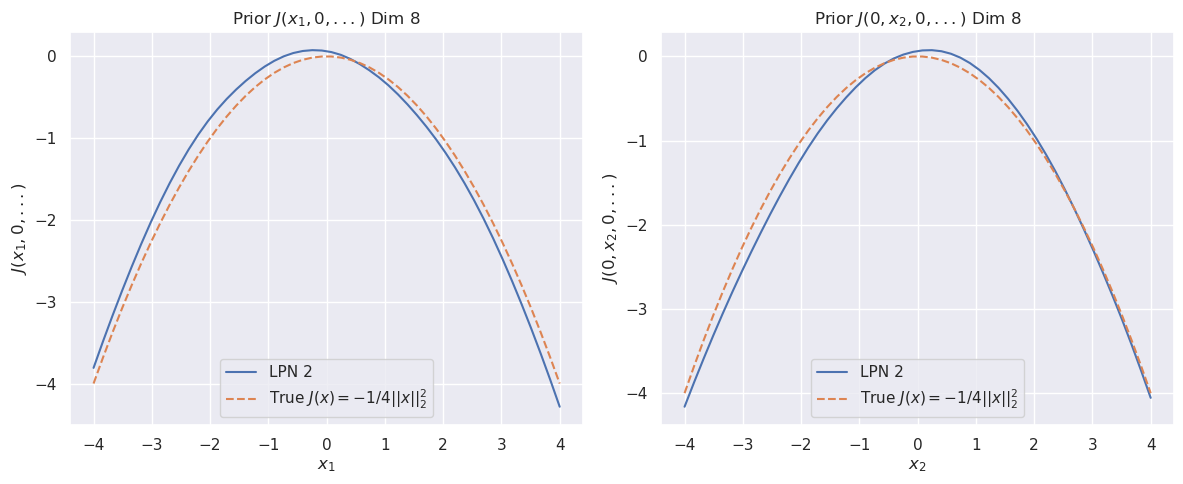

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)